# Registration

This notebook discusses the notion of registration, also called scan matching, that is **the process of finding a spatial transformation that aligns two overlapping pointclouds**. The result may then be used for 3D reconstruction (i.e., merging pointclouds obtained by scanning the same object/scene from different points of view) or for 3D pose estimation (i.e., finding the relative transformation between objects).

The scope is here limited to rigid registration, yielding a rigid transformation (i.e., a rotation and a translation), but note that non-rigid registration is also a thing. Also, note that this problem differs from a mere change of reference frames (where the reference frames of both pointclouds are known).


In [1]:
# Necessary imports
import sys
import time
import numpy as np
from scipy.spatial import KDTree
import matplotlib.pyplot as plt

sys.path.append("./utils")
from manip_utils import rotation_zyx

Just as in the case of fitting a model to data, the registration process comes down to minimizing a certain quantity materializing the distance between the two considered pointclouds. As often found in literature, **the pointcloud to be aligned is called the source** ("moving" pointcloud) and **the reference pointcloud is called the target** ("fixed" pointcloud). In this notebook, the source pointcloud is noted $P = \{p_0, p_1, ..., p_{n-1}\}$ and the target pointcloud is noted $Q= \{q_0, q_1, ..., q_{m-1}\}$.

This notion of distance to be minimized may take multiple forms, as we are about to see below.

## Registration between corresponding sets

In this section, we assume the correspondence of points between pointclouds $P$ and $Q$. This means that $P$ and $Q$ have the same number of points ($n = m$) and that $(p_i, q_i)$ is a pair of corresponding points $\forall i \in [0, n[$.

This configuration is for example found when artificial targets (e.g., adhesive reflective dots, spheres, or other artefacts) are used during the 3D acquisition process, providing a set of corresponding points between views. Correspondences may also be established using remarkable points present in both pointclouds.

For the sake of the example, the same pointcloud is used for the source and the target (it is assumed that `R_true` and `t_true` below are not known).


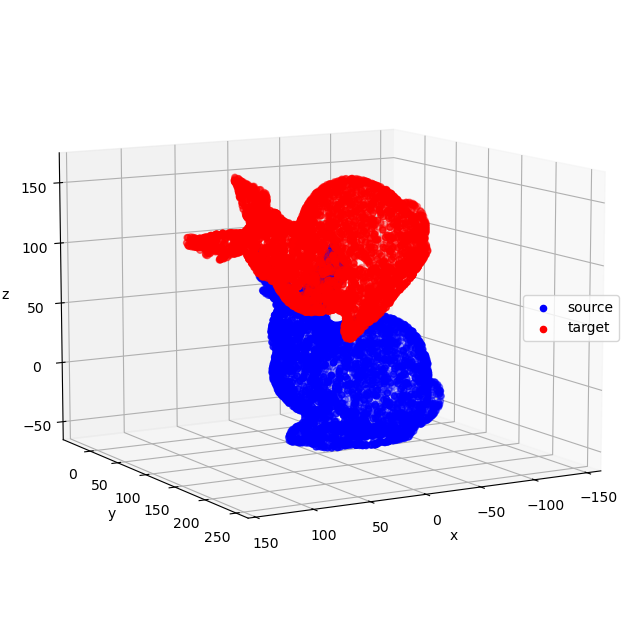

In [2]:
data = np.loadtxt("./data/stanford_bunny_custom.xyz")
points = data[:, :3]
normals = data[:, 7:]

R_true = rotation_zyx(theta_x=np.pi/5, theta_y=np.pi/6, theta_z=np.pi/7)
T_true = np.array([10., 20., 30.])

points_transformed = (R_true @ points.T).T + T_true
normals_transformed = (R_true @ normals.T).T          

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection="3d")
ax.scatter(points[:, 0], points[:, 1], points[:, 2],
           c='blue', label="source")
ax.scatter(points_transformed[:, 0], points_transformed[:, 1], points_transformed[:, 2],
           c='red', label="target")
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.legend(loc="right")
ax.view_init(10, 60)
plt.axis("equal")
plt.show()


### Point-to-point

The most straightforward approach consists in minimizing the sum of squared distances between pairs (i.e., each source point and its corresponding target point). This so called **point-to-point error metric**, may be written as follow:

\begin{equation*}
(R_{opt}, t_{opt}) = \arg\min_{R, t} \sum^{n-1}_{0} \omega_{i} || R \cdot p_{i} + t - q_{i} ||^{2}
\end{equation*}

Here $\omega_{i}$ represents the weight associated with each pair (which is equal to $1/n$ in case that all pairs have the same weight).

Fortunately, there is a direct method for calculating optimal parameters without resorting to traditional algorithms used to solve non-linear least squares problems.

The steps to computing the optimal rigid transformation are summarized as follow:
1. Compute the weighted centroids of both pointclouds

\begin{equation*}
\bar{p} = \frac{\sum^{n-1}_{i=0} \omega_i p_i}{\sum^{n-1}_{i=0} \omega_i} \quad \bar{q} = \frac{\sum^{n-1}_{i=0} \omega_i q_i}{\sum^{n-1}_{i=0} \omega_i}
\end{equation*}

2. Center both pointclouds around their centroids

\begin{equation*}
X = \{x_0, x_1, ..., x_{n-1}\}, \quad x_i = p_i - \bar{p}
\end{equation*}

\begin{equation*}
Y = \{y_0, y_1, ..., y_{n-1}\}, \quad y_i = q_i - \bar{q}
\end{equation*}

3. Compute the cross-covariance matrix of the centered pointclouds

\begin{equation*}
S = X W Y^T \quad \text{with} \quad W = diag(\omega_0, \omega_1, ..., \omega_{n-1})
\end{equation*}

4. Compute the singular value decomposition and deduce the optimal rotation

\begin{equation*}
R = V U^T \quad \text{with} \quad S = U \Sigma V^T
\end{equation*}

5. Deduce the optimal translation

\begin{equation*}
t = \bar{q} - R \bar{p}
\end{equation*}

More details can be found in the paper Sorkine-Hornung, O., & Rabinovich, M. (2017). Least-squares rigid motion using SVD. *Computing*, 1(1), 1-5.


In [3]:
def point_to_point_minimization(p, q, w):
    """Compute the best fitting rigid transformation (p to q) that minimizes
    the sum of squared distances between two sets of corresponding points"""

    # Compute the weighted centroids of both pointclouds
    p_bar = (w @ p)/w.sum()
    q_bar = (w @ q)/w.sum()
    # Compute the centered pointclouds
    x = p - p_bar
    y = q - q_bar
    # Cross covariance matrix
    S = x.T @ (w[:, None] * y)
    # Singular Value Decomposition
    U, _, V = np.linalg.svd(S)
    # Optimal rotation
    R = (U @ V).T
    # Symmetry test
    if np.linalg.det(R) < 0.0:
        V[2, :] *= -1
        R = (U @ V).T
    # Optimal translation
    T = q_bar - (R @ p_bar)

    return R, T

def point_to_point_error(p, q, w):
    """Compute the Root Mean Squared Error (RMS) for point-to-point distance"""

    se = ((w[:, None] * (p - q))**2).sum(axis=1)
    mse = se.mean()
    
    return np.sqrt(mse)
    

# Initial situation
weights = np.ones(len(points)) # use constant weights
initial_error = point_to_point_error(points, points_transformed, weights)
print("Initial error of", initial_error)

# Compute and apply the optimal transformation
R_point, T_point = point_to_point_minimization(points, points_transformed, weights)
points_transformed_calc = (R_point @ points.T).T + T_point
final_error = point_to_point_error(points_transformed_calc, points_transformed, weights)
print("Final error of", final_error)

# Check if similar to ground truth
print("Check if rotations R_true and R_point are the same:", np.allclose(R_true, R_point))
print("Check if translations T_true and T_point are the same:", np.allclose(T_true, T_point))


Initial error of 103.67099716102659
Final error of 4.747670110172861e-14
Check if rotations R_true and R_point are the same: True
Check if translations T_true and T_point are the same: True


### Point to plane

Another popular approach consists in minimizing the sum of squared distances between each source point and the tangent plane at its corresponding target point. This so called **point-to-plane error metric** may be written as follow:

\begin{equation*}
(R_{opt}, t_{opt}) = \arg\min_{R, t} \sum^{n-1}_{0} \omega_{i} [ (R \cdot p_{i} + t - q_{i}) \cdot n_{q, i} ]^{2}
\end{equation*}

$\omega_{i}$ is, again, the weight associated with each pair and $n_{q, i}$ is the unit normal vector associated to $q_i$.

Finding the optimal transformation $(R_{opt}, t_{opt})$ requires to solve a non-linear least squares optimization problem. While doable using minimization techniques, such as the Levenberg-Marquardt algorithm, it is in practice quite computationally costly (moreover if it must be repeated multiple times, but we'll get to it in the next section). Instead, an often-found solution consists in using a linear approximation, which is more easily solved.

Starting with the expression of the rotation matrix (extrinsic rotation z-y-x)

\begin{equation*}
R = 
\begin{pmatrix}
\cos\theta_y \cos\theta_z & \sin\theta_x \sin\theta_y \cos\theta_z - \cos\theta_x \sin\theta_z & \cos\theta_x \sin\theta_y \cos\theta_z + \sin\theta_x \sin\theta_z \\
\cos\theta_y \sin\theta_z & \sin\theta_x \sin\theta_y \sin\theta_z + \cos\theta_x \cos\theta_z & \cos\theta_x \sin\theta_y \sin\theta_z - \sin\theta_x \cos\theta_z \\
-\sin\theta_y & \sin\theta_x \cos\theta_y & \cos\theta_x \cos\theta_y \\
\end{pmatrix}
\end{equation*}

for small rotations ($\theta \approx 0$ so $\cos\theta \approx 1$ and $\sin\theta \approx \theta$) this matrix can be approximated by

\begin{equation*}
R_{linear} = 
\begin{pmatrix}
1 & \theta_z & \theta_y \\
\theta_z & 1 & \theta_x \\
-\theta_y & \theta_x & 1 \\
\end{pmatrix}
\end{equation*}

Thanks to this approximation, this problem can be formulated as a linear least squares problem $Ax = b$ with $x = [\theta_x, \theta_y, \theta_z, t_x, t_y, t_z]$, which requires far less computational resources.

Of course, the goodness of the result depends on the validity of the small-rotations approximation.

More details can be found in the paper Low, K. L. (2004). Linear least-squares optimization for point-to-plane ICP surface registration. *Chapel Hill, University of North Carolina*, 4(10), 1-3.



In [4]:
def point_to_plane_minimization(p, q, n_q, w):
    """Compute the best fitting rigit transformation (p to q) that minimizes
    the sum of squared distances between a data set of points and the tangent plane
    at its corresponding set of points in ref (linearized form)"""

    # Apply weight
    n_w = w[:, None] * n_q
    # Solving A.X = b (linearized form of the equation)
    A = np.hstack((np.cross(p, n_w), n_w))
    b = np.sum(n_w*(q-p), axis=1)
    x = np.linalg.pinv(A) @ b
    # Unpack result
    theta_x, theta_y, theta_z, t_x, t_y, t_z = x
    R = rotation_zyx(theta_x, theta_y, theta_z)
    T = np.array([t_x, t_y, t_z])

    return R, T

def point_to_plane_error(p, q, n_q, w):
    """Compute the Root Mean Squared Error (RMS) for point-to-plane distance"""

    se = (w[:, None] * (n_q * (p - q))**2).sum(axis=1)

    return se.mean()

# Initial situation (point-to-plane)
weights = np.ones(len(points))
initial_error = point_to_plane_error(points, points_transformed, normals_transformed, weights)
print("Initial error of", initial_error)

# Compute and apply the optimal transformation (point-to-plane)
R_plane, T_plane = point_to_plane_minimization(points, points_transformed, normals_transformed, weights)
points_transformed_calc = (R_point @ points.T).T + T_point
final_error = point_to_plane_error(points_transformed_calc, points_transformed, normals_transformed, weights)
print("Final error of", final_error)

# Check if similar to ground truth (but remember that we're comparing apples and oranges here)
print("Check if rotations R_true and R_plane are the same:", np.allclose(R_true, R_plane))
print("Check if translations T_true and T_plane are the same:", np.allclose(T_true, T_plane))



Initial error of 3795.315806850407
Final error of 1.403064182022662e-27
Check if rotations R_true and R_plane are the same: False
Check if translations T_true and T_plane are the same: False


## Registration between non-corresponding sets

In this section, we do not assume the correspondence between pointclouds $P$ and $Q$.

This configuration is for example found when the position of the acquisition device is not tracked or that no artificial targets are placed on the object of interest.

For the sake of the example, our initial pointcloud is split into two halves, one for the source and one for the target (it is assumed that `R_true` and `t_true` below are not known).


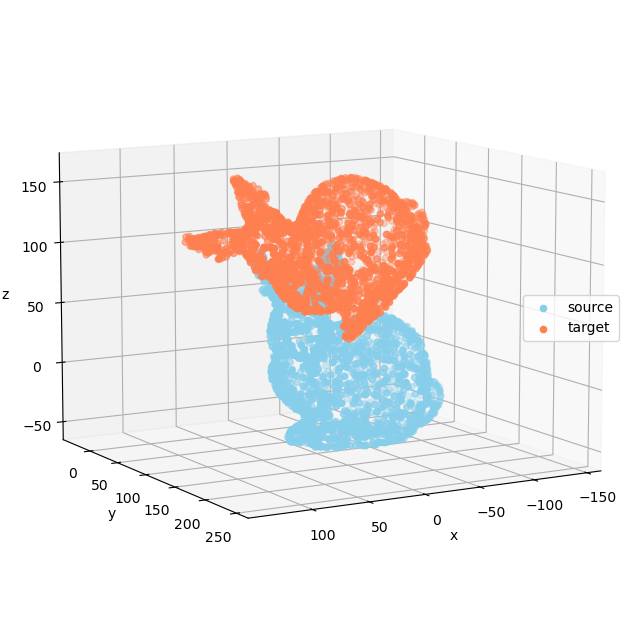

In [5]:
# Source = even indices
points_sub = points[::2]
normals_sub = normals[::2]

# Target = odd indices
points_transformed_sub = points_transformed[1::2]
normals_transformed_sub = normals_transformed[1::2]

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection="3d")
ax.scatter(points_sub[:, 0], points_sub[:, 1], points_sub[:, 2],
           c='skyblue', label="source")
ax.scatter(points_transformed_sub[:, 0], points_transformed_sub[:, 1], points_transformed_sub[:, 2],
           c='coral', label="target")
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.legend(loc="right")
ax.view_init(10, 60)
plt.axis("equal")
plt.show()

### The Iterative Closest Point (ICP) Algorithm

The Iterative Closest Point algorithm or ICP is unquestionably the most popular algorithm when it comes to pointcloud registration.

The algorithm was first described (almost simultaneously, with a few variations) in the following articles:
- Chen, Y., & Medioni, G. (1992). Object modelling by registration of multiple range images. *Image and vision computing*, 10(3), 145-155.
- Besl, P. J., & McKay, N. D. (1992). A method for registration of 3-D shapes. In *IEEE Transactions on Pattern Analysis and Machine Intelligence*, 14(2), 239-256

The basic algorithm is conceptually simple. Starting from two pointclouds, it iteratively:
1. Generates pairs of corresponding points between the source and the target pointclouds
2. Calculates the optimal transformation between these pairs
3. Applies this optimal transformation to the source pointcloud

Having already seen the last two steps of the algorithm (see previous sections), let's focus on the generation of corresponding pairs.

As described in the name of the algorithm, the corresponding point of a given point of the source pointcloud is its closest point (i.e., nearest neighbor) in the target pointcloud. This search process is repeated several times, meaning that pairs of corresponding points may change from one iteration to the next one.

In practice, the number of iterations is often a parameter of the algorithm, as seen below.


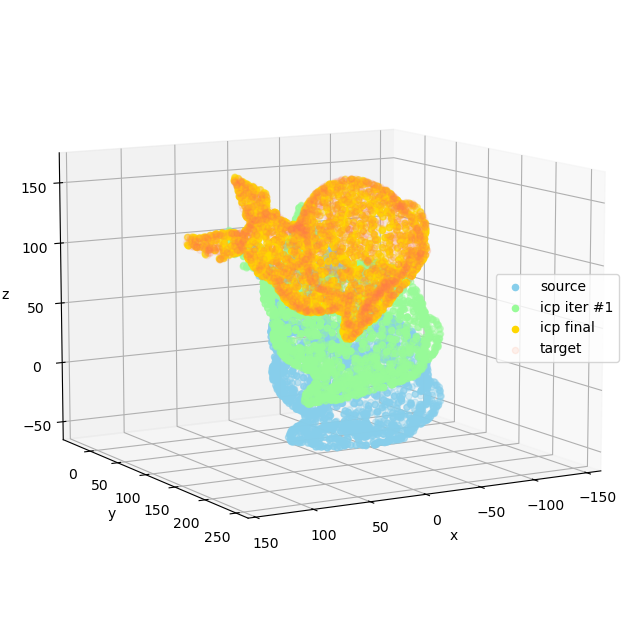

In [6]:
def register_simple_icp(source, target, max_iter):

    # Initialization
    kdtree = KDTree(target)
    Rt = [np.eye(3)]
    Tt = [np.zeros(3)]
    err = []

    for i in range(max_iter):

        # 1. Generate pairs
        _, match = kdtree.query(source)
        target_match = target[match]
        # 2. Compute the optimal transformation
        weights = np.ones(len(source))
        R, T = point_to_point_minimization(source, target_match, weights)
        # 3. Apply this transformation
        source = (R @ source.T).T + T
        rms = point_to_point_error(source, target_match, weights)

        # Store the result
        Rt.append(R @ Rt[i])
        Tt.append(R @ Tt[i] + T)
        err.append(rms)

    return Rt, Tt, err


Rt, Tt, err = register_simple_icp(points_sub, points_transformed_sub, 20)

points_sub_icp_1 = (Rt[1] @ points_sub.T).T + Tt[1]

points_sub_icp = (Rt[-1] @ points_sub.T).T + Tt[-1]


fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection="3d")
ax.scatter(points_sub[:, 0], points_sub[:, 1], points_sub[:, 2],
           c='skyblue', label="source")
ax.scatter(points_sub_icp_1[:, 0], points_sub_icp_1[:, 1], points_sub_icp_1[:, 2],
           c='palegreen', label="icp iter #1")
ax.scatter(points_sub_icp[:, 0], points_sub_icp[:, 1], points_sub_icp[:, 2],
           c='gold', label="icp final")
ax.scatter(points_transformed_sub[:, 0], points_transformed_sub[:, 1], points_transformed_sub[:, 2],
           c='coral', alpha=0.1, label="target")
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.legend(loc="right")
ax.view_init(10, 60)
plt.axis("equal")
plt.show()


It is then possible to track the error metric at each iteration to assess whether the algorithm is converging. Of course, the closest the final error value to zero the better but note that it would not likely fall down to zero if the source and target pointclouds are not strictly identical.


Check if rotations R_true and R_icp are the same: False
Check if translations T_true and T_icp are the same: False


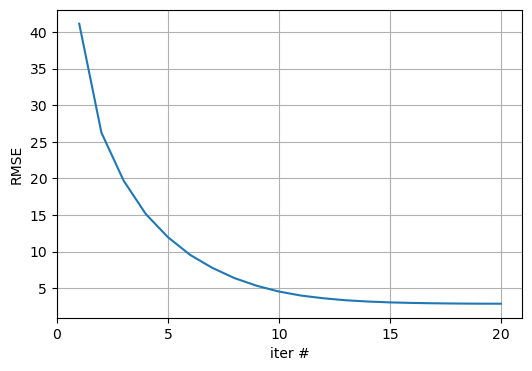

In [7]:
print("Check if rotations R_true and R_icp are the same:", np.allclose(R_true, Rt[-1]))
print("Check if translations T_true and T_icp are the same:", np.allclose(T_true, Tt[-1]))

fig = plt.figure(figsize=(6, 4))
ax = fig.add_subplot()
ax.plot(range(1, len(err)+1), err)
ax.set(xlabel='iter #', ylabel='RMSE',
       xticks=range(0, len(err)+1, 5))
ax.grid()
plt.show()

While three main phases are generally distinguished in the basic ICP algorithm (generation of pairs, estimation of the optimal transformation, and its application to the source pointcloud), some more advanced variants have been introduced over time. Several tentative have been made in an effort to summarize them, one of the most well-known being described in the following paper:

Rusinkiewicz, S., & Levoy, M. (2001). Efficient variants of the ICP algorithm. In *Proceedings of the third international conference on 3-D digital imaging and modeling*, pp. 145-152.

The authors introduced a few additional steps to categorize the different variants of the ICP algorithm. These steps are:
1. Selection of points
2. Matching points
3. Weighting of pairs
4. Rejecting pairs
5. Minimization of error metric

More details can be found in the paper, which also discusses the performances of the different variants depending on various considerations.

For the example, the following piece of code implement some of the most found strategies:
- Random selection of the source points


In [8]:
def register_icp(source, target, max_iter):

    # Initialization
    kdtree = KDTree(target)
    Rt = [np.eye(3)]
    Tt = [np.zeros(3)]
    err = []

    n_samples = int(len(souce)*0.5)
    
    for i in range(max_iter):

        # 1. selection of points
        random_sourc_inds = np.random.choice(n_samples, replace=False)
        source_sampled = source[random_source_inds]
        
        # 2. matching of points
        _, match = kdtree.query(source_sampled)
        target_match = target[match]

        # 3. weighting of pairs
        weights = np.ones(n_samples)

        # 4. rejecting pairs

        # 5. minimization of error metric
        R, T = point_to_point_minimization(source_sampled, target_match, weights)

        # Apply transform
        source = (R @ source.T).T + T # apply to the whole initial pointcloud
        
        rms = point_to_point_error(source_sampled, target_match, weights)

        # Store the result
        Rt.append(R @ Rt[i])
        Tt.append(R @ Tt[i] + T)
        err.append(rms)

    return Rt, Tt, err
    


While some strategies may improve the behavior of the ICP algorithm, its capacity to return the best transformation (i.e., the rotation matrix and the translation vector that minimize the distance between the two pointclouds) is not always guaranteed in practice. Indeed, the results of the ICP algorithm and its variants are known for being very sensitive to the initial alignment of the source and target pointclouds.

Said differently, if the rotation required to align both pointclouds is too large, the ICP algorithm often fails to find it. It "gets stuck" to a local optimum instead of converging to the global optimum, as illustrated below.


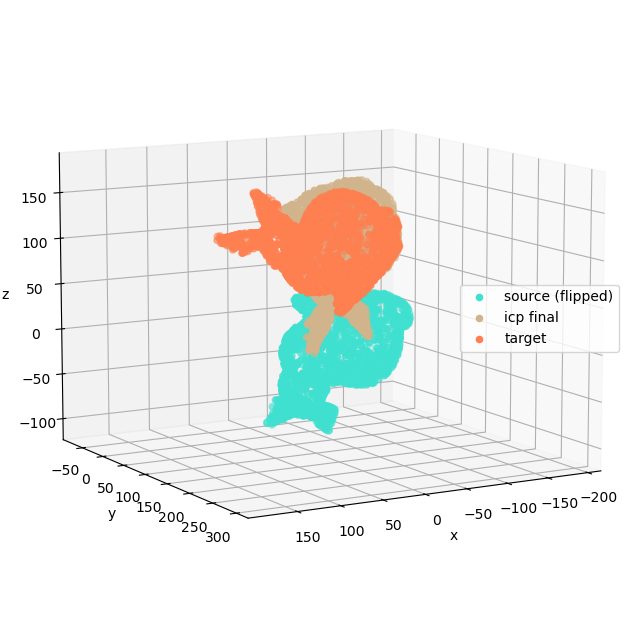

In [9]:
# Flip source
Rf_z = np.array([
    [1., 0., 0.],
    [0., 1., 0.],
    [0., 0., -1.]
])
points_flipped_sub = (Rf_z @ points_sub.T).T

Rt, Tt, err = register_simple_icp(points_flipped_sub, points_transformed_sub, 20)

points_flipped_sub_icp = (Rt[-1] @ points_flipped_sub.T).T + Tt[-1]


fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection="3d")
ax.scatter(points_flipped_sub[:, 0], points_flipped_sub[:, 1], points_flipped_sub[:, 2],
           c='turquoise', label="source (flipped)")
ax.scatter(points_flipped_sub_icp[:, 0], points_flipped_sub_icp[:, 1], points_flipped_sub_icp[:, 2],
           c='tan', label="icp final")
ax.scatter(points_transformed_sub[:, 0], points_transformed_sub[:, 1], points_transformed_sub[:, 2],
           c='coral', label="target")
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.legend(loc="right")
ax.view_init(10, 60)
plt.axis("equal")
plt.show()


This is why the ICP algorithm and its variants are often classified as local registration techniques. A rough estimate of the transformation between the views is often necessary for the algorithm to converge correctly.

This estimation can be carried out manually or by means of other algorithms.


### Global registration and Principal Axis Alignment

Unlike local registration techniques, global registration techniques do not rely on any initial alignment or hypothesis on the pose of the source and the target pointclouds. Their main quality typically lies in their robustness to initial alignment conditions or even to some other parameters such as noise or the percentage of overlap between the source and the target pointclouds.

Plenty of global registration algorithms have been proposed in the last decades. One of the easiest to understand relies on Principal Component Analysis (or PCA). It simply aims to align the principal directions of both pointclouds. Although not very robust to noise and requiring a good amount of overlap between the two poinclouds, this is one of the fastest techniques available and often a good first go-to algorithm. Furthermore, its steps are also quite similar to those of the algorithms discussed in the previous sections of this notebook.

The steps of this PCA-based global registration technique are summarized as follow:
1. Compute the centroids of both pointclouds

\begin{equation*}
\bar{p} = \frac{1}{n} \sum^{n-1}_{i=0} p_i \quad \bar{q} = \frac{1}{m} \sum^{m-1}_{i=0} q_i
\end{equation*}

2. Center both pointclouds around their centroids

\begin{equation*}
M = \{m_0, m_1, ..., m_{n-1}\}, \quad m_i = p_i - \bar{p}
\end{equation*}

\begin{equation*}
N = \{n_0, n_1, ..., n_{m-1}\}, \quad n_i = q_i - \bar{q}
\end{equation*}

3. Compute the singular value decomposition of the centered pointclouds and deduce the optimal rotation

\begin{equation*}
R = V_N^T V_M \quad \text{with} \quad M = U_M \Sigma_M V_M^T \quad \text{and} \quad N = U_N \Sigma_N V_N^T
\end{equation*}

4. Deduce the optimal translation

\begin{equation*}
t = \bar{q} - R \bar{p}
\end{equation*}

As you may see, this is quite similar to the point-to-point error minimization technique presented earlier.



In [10]:
def register_pca(p, q):
    """Compute the rigid transformation (p to q) that aligns the principal
    axis of the pointclouds"""

    # Compute centroids of both pointclouds
    p_bar = p.mean(axis=0)
    q_bar = q.mean(axis=0)
    
    # Compute the centered pointclouds
    M = p - p_bar
    N = q - q_bar

    # Singular Value Decomposition
    U_M, s_M, V_M = np.linalg.svd(M)
    U_N, s_N, V_N = np.linalg.svd(N)

    # Rotation matrix
    R = V_N.T @ V_M

    # Choice of the good symmetries
    candidates = []
    # x, y, and z
    for i in range(3):
        V_M1 = np.array(V_M)
        V_M1[i, :] *= -1
        candidates.append(V_N.T @ V_M1)
    # xyz
    candidates.append(-R)
    # xy, xz, and yz
    for i in range(3):
        V_M1 = np.array(V_M)
        V_M1[i, :] *= -1
        V_M1[i-1, :] *= -1
        candidates.append(V_N.T @ V_M1)
    # and 0
    candidates.append(R)

    # The best candidate is the one that obtains the best bounding box matches
    N_min = N.min(axis=0)
    N_max = N.max(axis=0)
    mismatch = np.inf
    
    for R in candidates:
        RM = R @ M.T
        RM_min = RM.min(axis=1)
        RM_max = RM.max(axis=1)
        d = np.linalg.norm(RM_min - N_min) + np.linalg.norm(RM_max - N_max)
        if d < mismatch:
            R_opt = R
            mismatch = d

    # Translation vector
    T_opt = q_bar - R_opt @ p_bar

    return R_opt, T_opt




In the example below, the PCA-based global registration technique aligns the two pointclouds almost perfectly.

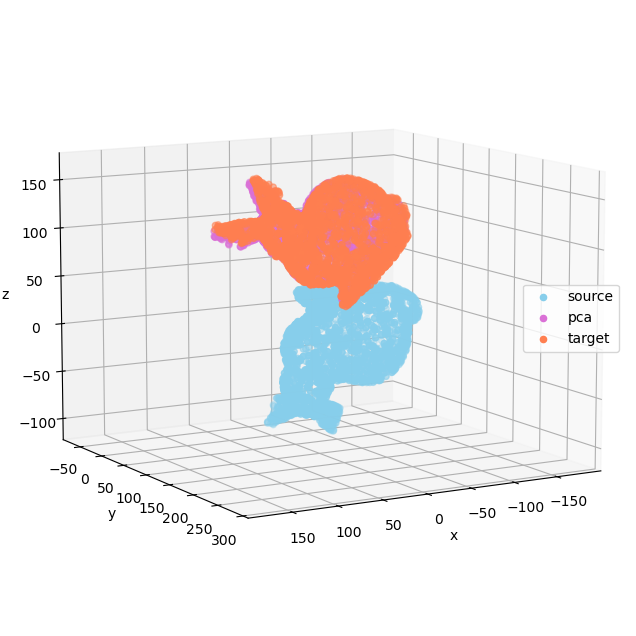

In [11]:
R_pca, T_pca = register_pca(points_flipped_sub, points_transformed_sub)

points_sub_pca = (R_pca @ points_flipped_sub.T).T + T_pca

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection="3d")
ax.scatter(points_flipped_sub[:, 0], points_flipped_sub[:, 1], points_flipped_sub[:, 2],
           c='skyblue', label="source")

ax.scatter(points_sub_pca[:, 0], points_sub_pca[:, 1], points_sub_pca[:, 2],
           c='orchid', label="pca")


ax.scatter(points_transformed_sub[:, 0], points_transformed_sub[:, 1], points_transformed_sub[:, 2],
           c='coral', label="target")
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.legend(loc="right")
ax.view_init(10, 60)
plt.axis("equal")
plt.show()


## Wrapping up

You should now have a better grasp of 3D point cloud registration, which aims to estimates the transformation that aligns two overlapping pointclouds. This problem is often found in computer vision and robotics in the context of scene/object reconstruction, localization/mapping, and object pose estimation. 

Registration algorithms are commonly classified into local and global categories. The first one includes the well-known ICP algorithm and its variants. Such algorithms return the best transformation parameters when both pointclouds are initially already quite-well aligned but are likely to fail to converge otherwise. On the other hand, global registration algorithms are robust to the initial alignment conditions but provide a less precise result. For this reason, global and local algorithms are often used sequentially during the registration process.


